# MLOps End to End Workflow

Implementation of an end-to-end ML Ops workflow for the use case to detect fraudulent credit card transactions, see [Kaggle dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

This notebook covers:

1. Set up: Creation of the Vertex Dataset, extraction of the schema
1. Implementation of a TFX pipeline and execution in Vertex Pipelines


## Setup

### Package installations

Run `pip install --user -r requirements.txt`

There will be an error upon importing tensorflow related to numpy. What fixed it was a forced reinstall of numpy:

`pip install numpy==1.21.6 --force-reinstall`

Moreover, install `libstdc++6`:

`sudo apt update`

`sudo apt install libstdc++6`


### Load data into BigQuery

Create a dataset called `vertex_eu` in the `EU` region.

To load the data into BQ:

```
$ bq load --skip_leading_rows=1 vertex_eu.creditcards creditcard.csv Time:STRING,V1:FLOAT,V2:FLOAT,V3:FLOAT,V4:FLOAT,V5:FLOAT,V6:FLOAT,V7:FLOAT,V8:FLOAT,V9:FLOAT,V10:FLOAT,V11:FLOAT,V12:FLOAT,V13:FLOAT,V14:FLOAT,V15:FLOAT,V16:FLOAT,V17:FLOAT,V18:FLOAT,V19:FLOAT,V20:FLOAT,V21:FLOAT,V22:FLOAT,V23:FLOAT,V24:FLOAT,V25:FLOAT,V26:FLOAT,V27:FLOAT,V28:FLOAT,Amount:FLOAT,Class:STRING
```

### Import Libraries


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

import yaml
import os

In [2]:
with open('mainconfig.yaml') as f:
    main_config = yaml.safe_load(f)

# select your config    
#main_config = main_config['personal']
main_config = main_config['caixa-novpcsc']

### Configuration

In [3]:
PROJECT = main_config['project'] 
REGION = main_config['region'] 

SERVICE_ACCOUNT = main_config['service_account']

print("Project ID:", PROJECT)
print("Region:", REGION)

# BigQuery and data locations

BQ_SOURCE_TABLE= main_config['bq']['source_table'] # raw input
ML_TABLE = main_config['bq']['ml_table'] # the one we will use for the training

BQ_DATASET_NAME = main_config['bq']['dataset']
BQ_LOCATION = main_config['bq']['location'] # multiregion provides more resilience

VERTEX_DATASET_NAME = main_config['vertex_dataset_name']

RAW_SCHEMA_DIR = main_config['raw_schema_dir']

BUCKET =  main_config['bucket']

# TFX and model config

# model version
VERSION = main_config['version']


MODEL_DISPLAY_NAME = f'{VERTEX_DATASET_NAME}-classifier-{VERSION}'
WORKSPACE = f'gs://{BUCKET}/{VERTEX_DATASET_NAME}'

MLMD_SQLLITE = 'mlmd.sqllite'
ARTIFACT_STORE = os.path.join(WORKSPACE, 'tfx_artifacts_interactive')
MODEL_REGISTRY = os.path.join(WORKSPACE, 'model_registry')
PIPELINE_NAME = f'{MODEL_DISPLAY_NAME}-train-pipeline'
PIPELINE_ROOT = os.path.join(ARTIFACT_STORE, PIPELINE_NAME)


DATAFLOW_SUBNETWORK = f"https://www.googleapis.com/compute/v1/projects/{PROJECT}/regions/{REGION}/subnetworks/{main_config['dataflow']['subnet']}"
DATAFLOW_SERVICE_ACCOUNT = main_config['dataflow']['service_account']

LIMIT=main_config['limit']

Project ID: cxb1-prj-test-no-vpcsc
Region: europe-west4


# Generate ML data

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.
This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

In [4]:
sql_script = f'''
CREATE OR REPLACE TABLE `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` 
AS (
    SELECT
      * EXCEPT(Class),
      CAST(Class AS FLOAT64) as Class,
      IF(ABS(MOD(FARM_FINGERPRINT(Time), 100)) <= 80, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      `{PROJECT}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE}`
)
'''

bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
job.result()

# Data Exploration

In [5]:
from google.cloud import bigquery

client = bigquery.Client()  

# I use the ML table here and I exclude the TIME and ML_USE columns, because I will later use this sample data to generate
# the schema for the training
sql = f"SELECT * EXCEPT(time, ml_use) FROM `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` LIMIT 1000"
print(sql)

query_job = client.query(sql, location=BQ_LOCATION)
sample_data = query_job.result().to_dataframe()

SELECT * EXCEPT(time, ml_use) FROM `cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml` LIMIT 1000


In [6]:
sample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.843098,2.250521,1.002586,2.140512,-0.243153,2.030701,-2.412078,-4.212585,-0.728707,-0.235210,...,1.038151,-0.336692,0.268674,-1.051860,-0.466004,0.035568,0.157281,0.162011,0.0,0.0
1,-5.147238,-5.566985,-1.542166,1.197280,5.698122,-4.619374,-1.786065,0.403203,-0.664867,-0.476083,...,0.965342,0.355864,-0.526838,0.861545,0.401519,0.577274,0.016674,-0.959417,0.0,0.0
2,2.180042,0.195697,-2.906568,0.047321,1.575817,-0.405608,0.861374,-0.372075,-0.416297,0.418885,...,0.253249,0.890952,-0.281670,-0.245863,0.808016,0.737577,-0.127611,-0.106866,0.0,0.0
3,-1.717260,2.002110,-1.422905,-1.343127,0.111744,-0.565402,0.030252,1.299018,-0.228588,-0.577674,...,-0.065837,-0.325268,-0.133153,-1.131302,0.141910,-0.052569,0.171394,0.126644,0.0,0.0
4,1.130646,0.625391,0.837987,2.506543,-0.107116,-0.245548,0.099603,-0.041457,-0.867319,0.623165,...,-0.017154,-0.014311,0.086559,0.393496,0.332062,-0.066378,0.013858,0.025382,0.0,0.0


In [7]:
%%bigquery counts --project {PROJECT} 

SELECT 
  Class, count(*) as n
FROM `vertex_eu.creditcards`
GROUP BY Class

Downloading: 100%|██████████| 2/2 [00:21<00:00, 10.57s/rows]


<AxesSubplot:xlabel='Class'>

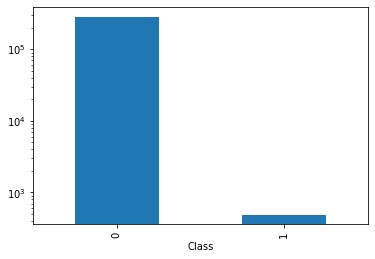

In [8]:
counts.plot(kind='bar', x='Class', y='n', logy=True, legend=False)

<AxesSubplot:>

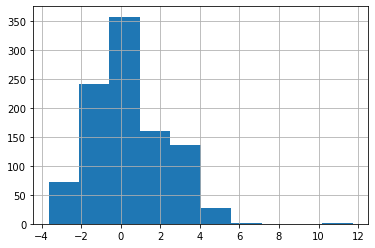

In [9]:
sample_data.V4.hist()

In [10]:
%%bigquery --project {PROJECT}

SELECT ML_use, Class, COUNT(*) as n
FROM vertex_eu.creditcards_ml
GROUP BY ML_use, Class

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.55rows/s]


,ML_use,Class,n
0,TEST,0.0,53405
1,TEST,1.0,90
2,UNASSIGNED,0.0,230910
3,UNASSIGNED,1.0,402


# Generate Schema


The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [11]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='Class',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [12]:
tfdv.visualize_statistics(stats)

In [13]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'V1',FLOAT,required,,-
'V2',FLOAT,required,,-
'V3',FLOAT,required,,-
'V4',FLOAT,required,,-
'V5',FLOAT,required,,-
'V6',FLOAT,required,,-
'V7',FLOAT,required,,-
'V8',FLOAT,required,,-
'V9',FLOAT,required,,-


In [14]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

# Create Vertex Dataset

In [15]:
print("Project ID:", PROJECT)
print("Region:", REGION)

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

Project ID: cxb1-prj-test-no-vpcsc
Region: europe-west4


In [16]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}"

dataset = vertex_ai.TabularDataset.create(
    display_name=VERTEX_DATASET_NAME, bq_source=bq_uri)

dataset.gca_resource

Creating TabularDataset
Create TabularDataset backing LRO: projects/1031952735253/locations/europe-west4/datasets/1088688035312173056/operations/8172890381340377088
TabularDataset created. Resource name: projects/1031952735253/locations/europe-west4/datasets/1088688035312173056
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/1031952735253/locations/europe-west4/datasets/1088688035312173056')


name: "projects/1031952735253/locations/europe-west4/datasets/1088688035312173056"
display_name: "creditcards"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1657097656
  nanos: 697125000
}
update_time {
  seconds: 1657097658
  nanos: 425428000
}
etag: "AMEw9yNL9Civ9AVukfdlqtpMwgjhWC-DAre8n3nG7NeeIWbcxLhI5HsPLQzOCXBHVkw9"
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "TABLE"
}
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

## Retrieve and inspect the Dataset

In [17]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={VERTEX_DATASET_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/1031952735253/locations/europe-west4/datasets/1088688035312173056
Dataset BigQuery source: bq://cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml


# Build the TFX Pipeline

In [18]:
import tfx.v1 as tfx
from tfx.extensions.google_cloud_big_query.example_gen.component import BigQueryExampleGen
from tfx.proto import example_gen_pb2, transform_pb2

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma
from tensorflow_transform.tf_metadata import schema_utils


import ml_metadata as mlmd
from ml_metadata.proto import metadata_store_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

import logging
import json

from src.common import features, datasource_utils
from src.model_training import data
from src.tfx_pipelines import components

In [19]:
logging.getLogger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

print("TFX Version:", tfx.__version__)
print("Tensorflow Version:", tf.__version__)

TFX Version: 1.8.0
Tensorflow Version: 2.8.2


In [20]:
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Project ID: cxb1-prj-test-no-vpcsc
Region: europe-west4
Bucket name: cxb1-prjtest-novpcsc-eu
Service Account: cxb1-prj-test-no-vpcsc@appspot.gserviceaccount.com
Vertex API Parent URI: projects/cxb1-prj-test-no-vpcsc/locations/europe-west4


## Create Interactive TFX Context

In [21]:
REMOVE_ARTIFACTS = True

if tf.io.gfile.exists(ARTIFACT_STORE) and REMOVE_ARTIFACTS:
    print("Removing previous artifacts...")
    tf.io.gfile.rmtree(ARTIFACT_STORE)
    
if tf.io.gfile.exists(MLMD_SQLLITE) and REMOVE_ARTIFACTS:
    print("Deleting previous mlmd.sqllite...")
    tf.io.gfile.rmtree(MLMD_SQLLITE)
    
print(f'Pipeline artifacts directory: {PIPELINE_ROOT}')
print(f'Local metadata SQLlit path: {MLMD_SQLLITE}')

Removing previous artifacts...
Deleting previous mlmd.sqllite...
Pipeline artifacts directory: gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline
Local metadata SQLlit path: mlmd.sqllite


In [22]:
connection_config = metadata_store_pb2.ConnectionConfig()
connection_config.sqlite.filename_uri = MLMD_SQLLITE
connection_config.sqlite.connection_mode = 3 # READWRITE_OPENCREATE
mlmd_store = mlmd.metadata_store.MetadataStore(connection_config)

context = InteractiveContext(
  pipeline_name=PIPELINE_NAME,
  pipeline_root=PIPELINE_ROOT,
  metadata_connection_config=connection_config
)

### Pipeline step 1: Hyperparameter generation

In [23]:
batch_size = 512

hyperparams_gen = components.hyperparameters_gen(
    num_epochs=5,
    learning_rate=0.001,
    batch_size=batch_size,
    hidden_units='64,64',
    steps_per_epoch=LIMIT // batch_size
)

context.run(hyperparams_gen, enable_cache=False)

ExecutionResult(
    component_id: hyperparameters_gen
    execution_id: 1
    outputs:
        hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=hyperparameters_gen, output_key=hyperparameters, additional_properties={}, additional_custom_properties={}))

#### Load the output of the component from Cloud Storage to check

In [24]:
gcs_uri_ouput = hyperparams_gen.outputs['hyperparameters'].get()[0].uri
gcs_uri_ouput

'gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline/hyperparameters_gen/hyperparameters/1'

In [25]:
json.load(
    tf.io.gfile.GFile(
        os.path.join(gcs_uri_ouput, 'hyperparameters.json')
    )
)

{'num_epochs': 5,
 'steps_per_epoch': 9,
 'batch_size': 512,
 'learning_rate': 0.001,
 'hidden_units': [64, 64]}

### Pipeline Step 2: Extract data from BQ onto Cloud Storage

In [26]:
def sql_query(ml_use, limit=None):
    return datasource_utils.get_training_source_query(PROJECT, REGION, VERTEX_DATASET_NAME, ml_use=ml_use, limit=limit)

def output_config(splits):
    return example_gen_pb2.Output(
        split_config=example_gen_pb2.SplitConfig(
            splits=[example_gen_pb2.SplitConfig.Split(name=split_name, hash_buckets=buckets) for (split_name, buckets) in splits]
        )
    )

train_example_gen = BigQueryExampleGen(query=sql_query('UNASSIGNED', LIMIT), output_config=output_config([('train', 4), ('eval', 1)]))

beam_pipeline_args=[
    f"--project={PROJECT}",
    f"--temp_location={os.path.join(WORKSPACE, 'tmp')}"
]

context.run(
    train_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 2
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [27]:
test_example_gen = BigQueryExampleGen(query=sql_query('TEST'), output_config=output_config([('test', 1)]))

context.run(
    test_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 3
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

#### Read some TFRecords from the training data

In [28]:
import numpy as np

In [29]:
train_uri = os.path.join(train_example_gen.outputs['examples'].get()[0].uri, "Split-train/*")

source_raw_schema = tfdv.load_schema_text(os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt'))
raw_feature_spec = schema_utils.schema_as_feature_spec(source_raw_schema).feature_spec

In [30]:
def _parse_tf_example(tfrecord):
    return tf.io.parse_single_example(tfrecord, raw_feature_spec)

tfrecord_filenames = tf.data.Dataset.list_files(train_uri)
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
dataset = dataset.map(_parse_tf_example)

for raw_features in dataset.shuffle(1000).batch(3).take(1):
    for key in raw_features:
        print(f"{key}: {np.squeeze(raw_features[key], -1)}")
    print("")

2022-07-06 08:56:01.885292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-06 08:56:01.885384: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 08:56:01.885428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1c7d0ba40b12): /proc/driver/nvidia/version does not exist
2022-07-06 08:56:01.885932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Amount: [0. 0. 0.]
Class: [0. 0. 0.]
V1: [1.0933999 1.1171894 1.2088823]
V10: [0.565179   0.7041668  0.66236895]
V11: [-0.02055417  0.93244755 -0.28961822]
V12: [0.6982089  0.93076444 0.70455706]
V13: [-0.54596245  0.23090787  1.5648257 ]
V14: [-0.46864712  0.20247622  0.02495182]
V15: [-2.119883   -0.7214131   0.26649565]
V16: [0.34054106 0.36915734 0.5181231 ]
V17: [-0.34371117 -0.471491   -0.6811909 ]
V18: [ 0.34081885 -0.4861917  -0.4815773 ]
V19: [-0.15019906 -0.65067154 -1.0143682 ]
V2: [0.04167349 0.45534435 0.75280356]
V20: [-0.19187082 -0.1633264  -0.06420054]
V21: [ 0.04631667 -0.16986445  0.0245134 ]
V22: [ 0.44209352 -0.40998438  0.13229844]
V23: [-0.17674403  0.0387424  -0.07234406]
V24: [ 0.048307   -0.31743008  0.41929024]
V25: [0.61775744 0.36622885 0.6209363 ]
V26: [ 0.21715552 -0.116817    0.03200055]
V27: [ 0.04192385  0.01366626 -0.00643245]
V28: [0.01261209 0.0075036  0.02187338]
V3: [1.3755862  0.65716594 0.5710454 ]
V4: [2.7241728 2.367039  2.4778814]
V5: [-0.639

### Pipeline step 3: Data Validation

Import the schema, generate statistics and validate the statistics against the schema.

In [31]:
schema_importer = tfx.dsl.Importer(
    source_uri=RAW_SCHEMA_DIR,
    artifact_type=tfx.types.standard_artifacts.Schema,
    reimport=False
)

context.run(schema_importer)

ExecutionResult(
    component_id: Importer
    execution_id: 4
    outputs:
        result: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 4
        type_id: 18
        uri: "src/raw_schema"
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.8.0"
          }
        }
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

Generate statistics

In [32]:
statistics_gen = tfx.components.StatisticsGen(
    examples=train_example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 5
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [33]:
!rm -rf {RAW_SCHEMA_DIR}/.ipynb_checkpoints/

Validate statistics against schema

In [34]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_importer.outputs['result'],
)

context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 6
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [35]:
context.show(example_validator.outputs['anomalies'])

### Pipeline Step 4: Data Preprocesing using TFX Transform (TFT)

In [36]:
_transform_module_file = 'src/preprocessing/transformations.py'

transform = tfx.components.Transform(
    examples=train_example_gen.outputs['examples'],
    schema=schema_importer.outputs['result'],
    module_file=_transform_module_file,
    splits_config=transform_pb2.SplitsConfig(
        analyze=['train'], transform=['train', 'eval']),
)

context.run(transform, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transformations.py -> build/lib
copying etl.py -> build/lib
installing to /tmp/tmphjtznbse
running install
running install_lib
copying build/lib/etl.py -> /tmp/tmphjtznbse
copying build/lib/transformations.py -> /tmp/tmphjtznbse
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmphjtznbse/tfx_user_code_Transform-0.0+fbce0ce0afea29fb286acdf8cf924e3de88d6a004802c1a9bee126280975cad7-py3.7.egg-info
running inst

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing /tmp/tmpkbalrdy2/tfx_user_code_Transform-0.0+fbce0ce0afea29fb286acdf8cf924e3de88d6a004802c1a9bee126280975cad7-py3-none-any.whl
Processing /tmp/tmpqash_zlq/tfx_user_code_Transform-0.0+fbce0ce0afea29fb286acdf8cf924e3de88d6a004802c1a9bee126280975cad7-py3-none-any.whl
Processing /tmp/tmpxrvh432u/tfx_user_code_Transform-0.0+fbce0ce0afea29fb286acdf8cf924e3de88d6a004802c1a9bee126280975cad7-py3-none-any.whl


2022-07-06 08:57:02.831715: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ExecutionResult(
    component_id: Transform
    execution_id: 7
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

#### Test: Read an example of the transformed data

In [37]:
transformed_train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, "Split-train/*")
transform_graph_uri = transform.outputs['transform_graph'].get()[0].uri

tft_output = tft.TFTransformOutput(transform_graph_uri)
transform_feature_spec = tft_output.transformed_feature_spec()

for input_features, target in data.get_dataset(
    transformed_train_uri, transform_feature_spec, batch_size=3, epochs=1).take(1):
    for key in input_features:
        print(f"{key} ({input_features[key].dtype}): {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

Amount (<dtype: 'float32'>): [[1.2150260210037231], [-0.29296788573265076], [-1.2982971668243408]]
V1 (<dtype: 'float32'>): [[-0.5861059427261353], [1.1469852924346924], [-1.6062641143798828]]
V10 (<dtype: 'float32'>): [[-0.4603950083255768], [0.42883914709091187], [-1.1142271757125854]]
V11 (<dtype: 'float32'>): [[-0.35986047983169556], [0.4641684591770172], [-0.8939840793609619]]
V12 (<dtype: 'float32'>): [[0.67806476354599], [1.0966076850891113], [-0.2855518162250519]]
V13 (<dtype: 'float32'>): [[0.8449413776397705], [1.217334508895874], [-1.3904426097869873]]
V14 (<dtype: 'float32'>): [[-0.3959377408027649], [0.6004251837730408], [1.2614469528198242]]
V15 (<dtype: 'float32'>): [[-0.053471557796001434], [-0.25509148836135864], [1.1022306680679321]]
V16 (<dtype: 'float32'>): [[-0.18976403772830963], [-0.1893346607685089], [-0.7357060313224792]]
V17 (<dtype: 'float32'>): [[-0.22434169054031372], [-1.0889372825622559], [1.3804519176483154]]
V18 (<dtype: 'float32'>): [[-0.70333182811737

### Pipeline Step 5: Model Training

In [38]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.experimental import latest_blessed_model_resolver

In [39]:
_train_module_file = 'src/model_training/runner.py'

trainer = tfx.components.Trainer(
    module_file=_train_module_file,
    examples=transform.outputs['transformed_examples'],
    schema=schema_importer.outputs['result'],
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=hyperparams_gen.outputs['hyperparameters'],
)

context.run(trainer, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying task.py -> build/lib
copying data.py -> build/lib
copying trainer.py -> build/lib
copying exporter.py -> build/lib
copying defaults.py -> build/lib
copying runner.py -> build/lib
installing to /tmp/tmpjtacc_0r
running install
running install_lib
copying build/lib/exporter.py -> /tmp/tmpjtacc_0r
copying build/lib/task.py -> /tmp/tmpjtacc_0r
copying build/lib/model.py -> /tmp/tmpjtacc_0r
copying build/lib/runner.py -> /tmp/tmpjtacc_0r
copying build/lib/data.py -> /tmp/tmpjtacc_0r
copying build/lib/defaults.py -> /tmp/tmpjtacc_0r
copying build/lib/trainer.py -> /tmp/tmpjtacc_0r
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manif

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing /tmp/tmprdepmwvp/tfx_user_code_Trainer-0.0+85b6a84b41132611be826aa547ec4889fc00a2da86863238ce5838cb7abd8f14-py3-none-any.whl
Epoch 1/5


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 6s 428ms/step - loss: 0.5534 - accuracy: 0.7967 - auc: 0.0479 - val_loss: 0.3407 - val_accuracy: 0.9951 - val_auc: 0.0033
Epoch 2/5
9/9 [==============================] - 2s 193ms/step - loss: 0.2612 - accuracy: 0.9933 - auc: 0.0036 - val_loss: 0.1715 - val_accuracy: 0.9951 - val_auc: 0.0029
Epoch 3/5
9/9 [==============================] - 2s 193ms/step - loss: 0.1353 - accuracy: 0.9954 - auc: 0.0024 - val_loss: 0.1016 - val_accuracy: 0.9951 - val_auc: 0.0030
Epoch 4/5
9/9 [==============================] - 2s 195ms/step - loss: 0.0825 - accuracy: 0.9952 - auc: 0.0026 - val_loss: 0.0680 - val_accuracy: 0.9951 - val_auc: 0.0034
Epoch 5/5
9/9 [==============================] - 2s 190ms/step - loss: 0.0665 - accuracy: 0.9941 - auc: 0.0050 - val_loss: 0.0454 - val_accuracy: 0.9951 - val_auc: 0.0328


ExecutionResult(
    component_id: Trainer
    execution_id: 8
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

### Pipeline Step 6: Model Evaluation

#### Get the latest blessed model for model validation

In [40]:
blessed_model_resolver = Resolver(
    strategy_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
    model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
    model_blessing=tfx.dsl.Channel(type=tfx.types.standard_artifacts.ModelBlessing)
)

context.run(blessed_model_resolver, enable_cache=False)

ExecutionResult(
    component_id: Resolver
    execution_id: 9
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Resolver, output_key=model, additional_properties={}, additional_custom_properties={})
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}))

#### Evaluate the model and compare against the baseline

In [41]:
from tfx.components import Evaluator

In [42]:
eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(
            signature_name='serving_tf_example',
            label_key=features.TARGET_FEATURE_NAME,
            prediction_key='probabilities')
    ],
    slicing_specs=[
        tfma.SlicingSpec(),
    ],
    metrics_specs=[
        tfma.MetricsSpec(
            metrics=[   
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(
                    class_name='BinaryAccuracy',
                    threshold=tfma.MetricThreshold(
                        value_threshold=tfma.GenericValueThreshold(
                            lower_bound={'value': 0.1}), ## note setting a very low barrier for this example
                        # Change threshold will be ignored if there is no
                        # baseline model resolved from MLMD (first run).
                        change_threshold=tfma.GenericChangeThreshold(
                            direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                            absolute={'value': -1e-10}))),
        ])
    ])


evaluator = Evaluator(
    examples=test_example_gen.outputs['examples'],
    example_splits=['test'],
    model=trainer.outputs['model'],
    baseline_model=blessed_model_resolver.outputs['model'],
    eval_config=eval_config,
    schema=schema_importer.outputs['result']
)

context.run(evaluator, enable_cache=False)

ExecutionResult(
    component_id: Evaluator
    execution_id: 10
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [43]:
evaluation_results = evaluator.outputs['evaluation'].get()[0].uri
print("validation_ok:", tfma.load_validation_result(evaluation_results).validation_ok, '\n')

for entry in list(tfma.load_metrics(evaluation_results))[0].metric_keys_and_values:
    value = entry.value.double_value.value
    if value:
        print(entry.key.name, ":", round(entry.value.double_value.value, 3))

validation_ok: True 

accuracy : 0.389
auc : 0.007
loss : 0.975
example_count : 53495.0
binary_accuracy : 0.389


### Pipeline Step 7: Push model to Cloud Storage

In [44]:
exported_model_location = os.path.join(MODEL_REGISTRY, MODEL_DISPLAY_NAME)

push_destination=tfx.proto.PushDestination(
    filesystem=tfx.proto.PushDestination.Filesystem(
        base_directory=exported_model_location,
    )
)

pusher = tfx.components.Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=push_destination
)

context.run(pusher, enable_cache=False)

ExecutionResult(
    component_id: Pusher
    execution_id: 11
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))

### Pipeline Step 8: Upload model to Vertex AI

In [45]:
serving_runtime = 'tf2-cpu.2-5'
serving_image_uri = f"us-docker.pkg.dev/vertex-ai/prediction/{serving_runtime}:latest"

labels = {
    'dataset_name': VERTEX_DATASET_NAME,
    'pipeline_name': PIPELINE_NAME
}
labels = json.dumps(labels)

vertex_model_uploader = components.vertex_model_uploader(
    project=PROJECT,
    region=REGION,
    model_display_name=MODEL_DISPLAY_NAME,
    pushed_model_location=exported_model_location,
    serving_image_uri=serving_image_uri,
    model_blessing=evaluator.outputs['blessing'],
    explanation_config='',
    labels=labels
)

context.run(vertex_model_uploader, enable_cache=False)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/1031952735253/locations/europe-west4/models/6981828467633422336/operations/1304900949600370688


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/1031952735253/locations/europe-west4/models/6981828467633422336/operations/1304900949600370688


Model created. Resource name: projects/1031952735253/locations/europe-west4/models/6981828467633422336


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/1031952735253/locations/europe-west4/models/6981828467633422336


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/1031952735253/locations/europe-west4/models/6981828467633422336')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/1031952735253/locations/europe-west4/models/6981828467633422336')


ExecutionResult(
    component_id: vertex_model_uploader
    execution_id: 12
    outputs:
        uploaded_model: OutputChannel(artifact_type=File, producer_component_id=vertex_model_uploader, output_key=uploaded_model, additional_properties={}, additional_custom_properties={}))

In [46]:
vertex_model_uploader.outputs['uploaded_model'].get()[0].uri

'gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline/vertex_model_uploader/uploaded_model/12'

## Unit Testing

In [69]:
os.environ["VERTEX_DATASET_NAME"] = VERTEX_DATASET_NAME
os.environ["MODEL_DISPLAY_NAME"] =  MODEL_DISPLAY_NAME
os.environ["PIPELINE_NAME"] = PIPELINE_NAME
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BQ_LOCATION"] = BQ_LOCATION
os.environ["BQ_DATASET_NAME"] = BQ_DATASET_NAME
os.environ["ML_TABLE"] = ML_TABLE
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/e2e_tests"
os.environ["TRAIN_LIMIT"] = "1000"
os.environ["TEST_LIMIT"] = "100"
os.environ["UPLOAD_MODEL"] = "1"
os.environ["ACCURACY_THRESHOLD"] = "-0.1"    # NB Negative accuracy threshold makes no sense - allows everything
os.environ["BEAM_RUNNER"] = "DirectRunner"
os.environ["TRAINING_RUNNER"] = "local"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT


In [70]:
from src.tfx_pipelines import config
import importlib
importlib.reload(config)

for key, value in config.__dict__.items():
    if key.isupper(): print(f'{key}: {value}')

PROJECT: cxb1-prj-test-no-vpcsc
REGION: europe-west4
GCS_LOCATION: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests
ARTIFACT_STORE_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests/tfx_artifacts
MODEL_REGISTRY_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests/model_registry
VERTEX_DATASET_NAME: creditcards
MODEL_DISPLAY_NAME: creditcards-classifier-v01
PIPELINE_NAME: creditcards-classifier-v01-train-pipeline
ML_USE_COLUMN: ml_use
EXCLUDE_COLUMNS: trip_start_timestamp
TRAIN_LIMIT: 1000
TEST_LIMIT: 100
SERVE_LIMIT: 0
NUM_TRAIN_SPLITS: 4
NUM_EVAL_SPLITS: 1
ACCURACY_THRESHOLD: -0.1
USE_KFP_SA: False
TFX_IMAGE_URI: europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest
BEAM_RUNNER: DirectRunner
SERVICE_ACCOUNT: cxb1-prj-test-no-vpcsc@appspot.gserviceaccount.com
SUBNETWORK: https://www.googleapis.com/compute/v1/projects/cxb1-prj-test-no-vpcsc/regions/europe-west4/subnetworks/default
BEAM_DIRECT_PIPELINE_ARGS: ['--project=cxb1-prj-test-no-vpcsc', '--temp_lo

In [71]:
!python -m pytest src/tests/datasource_utils_tests.py -s

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/mlops-with-vertex-ai
plugins: anyio-3.6.1
collected 2 items                                                              

src/tests/datasource_utils_tests.py BigQuery Source: cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml
.BigQuery Source: cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml
.

============================== 2 passed in 7.55s ===============================


In [73]:
!python -m pytest src/tests/model_tests.py -s

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/mlops-with-vertex-ai
plugins: anyio-3.6.1
collected 3 items                                                              

src/tests/model_tests.py .s2022-07-06 09:11:29.528839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-06 09:11:29.528885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 09:11:29.528915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1c7d0ba40b12

#### End to end pipeline unit test

In [74]:
!python -m pytest src/tests/pipeline_deployment_tests.py::test_e2e_pipeline -s

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/mlops-with-vertex-ai
plugins: anyio-3.6.1
collected 0 items / 1 error                                                    

==================================== ERRORS ====================================
___________ ERROR collecting src/tests/pipeline_deployment_tests.py ____________
ImportError while importing test module '/home/jupyter/mlops-with-vertex-ai/src/tests/pipeline_deployment_tests.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
/opt/conda/lib/python3.7/importlib/__init__.py:127: in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
src/tests/pipeline_deployment_tests.py:18: in <module>
    from tfx.orchestration.local.local_dag_runner import LocalDagRunner
../.local/lib/python3.7/site-packages/tfx/orchestration/local/local_dag_runner.py:21: in <modul

INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob run completed. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706090427


## Deploy to Vertex AI Pipelines

In [4]:
os.environ["VERTEX_DATASET_NAME"] = VERTEX_DATASET_NAME
os.environ["MODEL_DISPLAY_NAME"] = MODEL_DISPLAY_NAME
os.environ["PIPELINE_NAME"] = PIPELINE_NAME
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}"
os.environ["TRAIN_LIMIT"] = "85000"
os.environ["TEST_LIMIT"] = "15000"
os.environ["BEAM_RUNNER"] = "DataflowRunner"
os.environ["TRAINING_RUNNER"] = "vertex"
os.environ["TFX_IMAGE_URI"] = f"{REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/vertex:latest"
os.environ["ENABLE_CACHE"] = "1"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK
os.environ["SERVICE_ACCOUNT"] = DATAFLOW_SERVICE_ACCOUNT

In [7]:
from src.tfx_pipelines import config

In [8]:
config.BEAM_RUNNER

'DataflowRunner'

### Create Repo for Image

In [53]:
!gcloud artifacts repositories create {VERTEX_DATASET_NAME} --location={REGION} --repository-format=docker

Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 132, in <module>
    main()
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 90, in main
    from googlecloudsdk.core.util import encoding
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, in <module>
    from importlib._bootstrap import _ERR_MSG, _exec, _load, _builtin_from_name
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 51, in <module>
    _w_long = _bootstrap_external._w_long
AttributeError: module 'importlib._bootstrap_external' has no attribute '_w_long'


### Build Vertex worker image

In [54]:
!echo $TFX_IMAGE_URI

europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest


In [55]:
!cp build/Dockerfile.vertex Dockerfile
!gcloud builds submit --tag $TFX_IMAGE_URI . --timeout=15m --machine-type=e2-highcpu-8 --billing-project=$PROJECT --suppress-logs

Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 132, in <module>
    main()
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 90, in main
    from googlecloudsdk.core.util import encoding
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, in <module>
    from importlib._bootstrap import _ERR_MSG, _exec, _load, _builtin_from_name
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 51, in <module>
    _w_long = _bootstrap_external._w_long
AttributeError: module 'importlib._bootstrap_external' has no attribute '_w_long'


### Compile the pipeline

In [9]:
from src.tfx_pipelines import config, runner

pipeline_definition_file = f'{config.PIPELINE_NAME}.json'
pipeline_definition = runner.compile_training_pipeline(pipeline_definition_file)

Labels for model: {"dataset_name": "creditcards", "pipeline_name": "creditcards-classifier-v01-train-pipeline", "pipeline_root": "gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts/creditc"}
running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transformations.py -> build/lib
copying etl.py -> build/lib
installing to /tmp/tmp_a1foxli
running install
running install_lib
copying build/lib/etl.py -> /tmp/tmp_a1foxli
copying build/lib/transformations.py -> /tmp/tmp_a1foxli
running install_egg_info
running egg_info
creating tfx_user_code_DataTransformer.egg-info
writing tfx_user_code_DataTransformer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_DataTransformer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_DataTransformer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_DataTransformer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_DataTransformer.egg-info/SOURCES.txt'
writing manifest fi

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying task.py -> build/lib
copying data.py -> build/lib
copying trainer.py -> build/lib
copying exporter.py -> build/lib
copying defaults.py -> build/lib
copying runner.py -> build/lib
installing to /tmp/tmpcm73fz88
running install
running install_lib
copying build/lib/exporter.py -> /tmp/tmpcm73fz88
copying build/lib/task.py -> /tmp/tmpcm73fz88
copying build/lib/model.py -> /tmp/tmpcm73fz88
copying build/lib/runner.py -> /tmp/tmpcm73fz88
copying build/lib/data.py -> /tmp/tmpcm73fz88
copying build/lib/defaults.py -> /tmp/tmpcm73fz88
copying build/lib/trainer.py -> /tmp/tmpcm73fz88
running install_egg_info
running egg_info
creating tfx_user_code_ModelTrainer.egg-info
writing tfx_user_code_ModelTrainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_ModelTrainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_ModelTrainer.egg-info/top_lev

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


In [10]:
PIPELINES_STORE = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/compiled_pipelines/"
!gsutil cp {pipeline_definition_file} {PIPELINES_STORE}

Copying file://creditcards-classifier-v01-train-pipeline.json [Content-Type=application/json]...
/ [1 files][ 32.2 KiB/ 32.2 KiB]                                                
Operation completed over 1 objects/32.2 KiB.                                     


### Submit Vertex AI Pipelines run

In [11]:
from google.cloud.aiplatform import pipeline_jobs
    
job = pipeline_jobs.PipelineJob(template_path = pipeline_definition_file,
                                display_name=VERTEX_DATASET_NAME,
                                #enable_caching=False,
                                parameter_values={
                                    'learning_rate': 0.003,
                                    'batch_size': 512,
                                    'steps_per_epoch': int(config.TRAIN_LIMIT) // 512,
                                    'hidden_units': '128,128',
                                    'num_epochs': 30,
                                })

job.run(sync=False, service_account=DATAFLOW_SERVICE_ACCOUNT)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v01-train-pipeline-20220706111940?project=1031952735253


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v01-train-pipeline-20220706111940?project=1031952735253


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220706111940 current state:
PipelineState.PIPELINE_STATE_RUNNING
